# CNN learning for arrhythmia classification

## Import libraries

In [15]:
from __future__ import division, print_function

import json

import sys
import os
import glob
import re
import wfdb
import cv2
import pandas as pd
import numpy as np
import biosppy
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

# Keras
import keras
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import save_model, load_model
from keras.preprocessing import image
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, ELU, Dropout, Dense, Flatten
from keras import backend as K
import tensorflow as tf

C:\Users\Asus\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preprocess data

Get all records names from [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/)

In [81]:
records = wfdb.get_record_list('mitdb')
records[:10]

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']

We need images of beats to learn CNN. So create and save images and labels for each beat of all records

In [60]:
def signal_to_image(signal, folder_name, record_ind, signal_ind):
    fig = plt.figure(frameon=False)
    plt.plot(signal, linewidth=3.5) 
    plt.xticks([]), plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    filename = folder_name + '/' + str(record_ind) + '_' + str(signal_ind) + '.png'
    
    fig.savefig(filename)
    im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    im_gray = cv2.resize(im_gray, (128, 128))
    cv2.imwrite(filename, im_gray)
    plt.close(fig)

    return im_gray

In [95]:
class_to_idx = {'nor': 1, 'lbb': 2, 'rbb': 5, 'apc': 0, 'pvc': 4, 'pab': 3, 'veb': 6, 'vfw': 7}

In [96]:
idx_to_class = dict(zip(class_to_idx.values(), class_to_idx.keys()))
idx_to_class

{0: 'apc',
 1: 'nor',
 2: 'lbb',
 3: 'pab',
 4: 'pvc',
 5: 'rbb',
 6: 'veb',
 7: 'vfw'}

In [97]:
symbol_to_label = {'N':'nor', 'L':'lbb', 'R':'rbb', 'A':'apc', 
                   'V':'pvc', '/':'pab', 'E':'veb', '!':'vfw'}

In [87]:
signal_ind = 0
for record_ind, record in enumerate(records):
    signals = wfdb.rdsamp(record, channels=[0], pb_dir='mitdb')[0]
    ann = wfdb.rdann(record, 'atr', pb_dir='mitdb') 
    symbols = ann.symbol
    beats = list(ann.sample)

    for i in range(len(beats)):
        if symbols[i] in list(symbol_to_label.keys()):
            left_ind = 0 if i == 0 else beats[i - 1] + 20
            right_ind = len(signals) if i == len(beats) - 1 else beats[i + 1] - 20
            signal = signals[left_ind: right_ind]

            signal_to_image(signal, 'signal_images', record_ind, signal_ind)
    
            with open('labels.txt', 'a') as f:
                f.write(str(record_ind) + '_' + str(signal_ind) + ' ' + str(class_to_idx[symbol_to_label[symbols[i]]]))
                f.write('\n')
                
            signal_ind += 1

    print(record_ind, end=' ')

## Prepare train dataset

Get images paths and get images IDs from the paths

In [83]:
all_paths = glob.glob('./signal_images/*.png')

cropped_paths = {}
beg = all_paths[0].find('\\') + 1
for path in all_paths:
    end = path.rfind('.')
    
    number = path[beg:end]
    record_n = int(number[:number.find('_')])
    sig_n = int(number[number.find('_') + 1:])
    
    if cropped_paths.get(record_n) is None:
        cropped_paths[record_n] = 0
    cropped_paths[record_n] += 1

Read images labels from the file

In [84]:
id_labels = {}
with open('labels.txt', 'r') as f:
    for line in f:
        n, l = line.split()
        id_labels[n] = int(l)

len(id_labels)

107668

Tha dataset is imbalanced, so we'll need to artificially augment smaller classes

In [85]:
np.unique(list(id_labels.values()), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 2546, 75052,  8075,  7028,  7130,  7259,   106,   472],
       dtype=int64))

Create a list of labels from the dictionary

In [86]:
labels = np.array(list(id_labels.values()))
len(labels)

107668

In [87]:
NUM_CLASSES = len(np.unique(labels))
NUM_CLASSES

8

Shuffle data for learning

In [88]:
indices = np.arange(len(labels))
np.random.seed(123)
np.random.shuffle(indices)

print(len(indices), indices)

107668 [23423 48798  7516 ... 17730 28030 15725]


## Training generators

This method augments smaller classes ten times cropping and shifting images

In [89]:
def get_cropping_images(image):
    #Left Top Crop
    left_top = cv2.resize(image[:96, :96], (128, 128))

    #Center Top Crop
    center_top = cv2.resize(image[:96, 16:112], (128, 128))

    #Right Top Crop
    right_top = cv2.resize(image[:96, 32:], (128, 128))

    #Left Center Crop
    left_center = cv2.resize(image[16:112, :96], (128, 128))

    #Center Center Crop
    center_center = cv2.resize(image[16:112, 16:112], (128, 128))

    #Right Center Crop    
    right_center = cv2.resize(image[16:112, 32:], (128, 128))

    #Left Bottom Crop
    left_bottom = cv2.resize(image[32:, :96], (128, 128))

    #Center Bottom Crop
    center_bottom = cv2.resize(image[32:, 16:112], (128, 128))

    #Right Bottom Crop    
    right_bottom = cv2.resize(image[32:, 32:], (128, 128))

    return np.array([left_top, center_top, right_top,
            left_center, center_center, right_center,
            left_bottom, center_bottom, right_bottom])

We'll use generators to train CNN

In [90]:
def get_generator(ind, augment=False):
    image = cv2.imread(all_paths[ind], cv2.IMREAD_GRAYSCALE)
    number_path = all_paths[ind][all_paths[ind].find('\\') + 1 : all_paths[ind].rfind('.')]
    label = id_labels[number_path]
    
    if augment and label != class_to_idx['nor']:
        cropped_images = get_cropping_images(image)
        images = np.vstack((np.expand_dims(image, axis=0), cropped_images)) 
        yield images, [label] * len(images)
    else:
        yield np.expand_dims(image, 0), [label]

In [91]:
def raw_batch_generator(batch_size, augment=False, debug=False):
    global batch_i
    
    generators = np.array([get_generator(ind, augment) for ind in range(len(all_paths))])
    while True:
        batch_indices = indices[(batch_i - 1) * batch_size : batch_i * batch_size]
        batch_i += 1
        yield [gen.__next__() for gen in generators[batch_indices]]

In [92]:
def images_and_labels_generator(batch_size, augment=False):
    for batch in raw_batch_generator(batch_size, augment):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(e[0])
            batch_labels.extend(e[1])
        batch_images = np.stack(batch_images, axis=0) if not augment else np.vstack(batch_images)
        yield batch_images, batch_labels

In [93]:
def train_iterator(batch_size, augment=False):      
    for batch in images_and_labels_generator(batch_size, augment):
        batch_images = batch[0]
        batch_images = np.expand_dims(batch_images, -1)
        batch_labels = keras.utils.to_categorical(batch[1], NUM_CLASSES)
        yield batch_images, batch_labels

Test train generator

In [98]:
batch_i = 1
train_iterator(32, augment=True).__next__()[0].shape

(104, 128, 128, 1)

## Prepare CNN model

In [107]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

Class for saving model after each epoch

In [88]:
class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name
        self.f1s = []
        
    def on_epoch_end(self, epoch, logs=None):     
        model_filename = self.file_name.format(epoch % 3)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))
        return

Custom F1 score mectric for measuring training quality

In [101]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1_val = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
            
    return f1_val

Define parameters for CNN training

In [109]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
STEPS_PER_EPOCH = 50
EPOCHS = 100

Define model architecture

In [38]:
s = reset_tf_session()

In [39]:
model = Sequential()

model.add(Conv2D(64, (3, 3),strides=(1,1), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3),strides=(1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), strides = (1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3),strides=(1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), strides=(1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3),strides=(1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(2048))
model.add(ELU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax'))

model.summary()

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',  # gradient clipping just in case
  metrics=[keras.metrics.categorical_accuracy, f1] 
)  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
elu_1 (ELU)                  (None, 126, 126, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
elu_2 (ELU)                  (None, 124, 124, 64)      0         
_________________________________________________________________
batch_normalization_2

Count class weights to cope with imbalanced dataset during training

In [104]:
labels_for_weights = labels
for ind in [0, 2, 3, 4, 5, 6, 7]:
    new_labels = np.full(sum(labels == ind) * 9, ind)
    labels_for_weights = np.append(labels_for_weights, new_labels)
len(labels_for_weights)

401212

In [105]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(labels_for_weights), labels_for_weights)
class_weights

array([ 1.9698154 ,  0.66822337,  0.62107121,  0.71359562,  0.7033871 ,
        0.69088717, 47.31273585, 10.6253178 ])

## CNN training

In [1]:
MODEL_FNAME = 'model_v3_{}'

In [48]:
batch_i = 1
hist = History()

model.fit_generator(
    train_iterator(BATCH_SIZE, True), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(MODEL_FNAME), hist],
    verbose=1,  
    class_weight=class_weights,
    initial_epoch=0
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
50/50 [==============================] - 2505s 50s/step - loss: 3.0487 - categorical_accuracy: 0.5202 - f1: 0.5125
Model saved in model_v3_0
Epoch 2/100
50/50 [==============================] - 2041s 41s/step - loss: 1.9249 - categorical_accuracy: 0.6332 - f1: 0.6229
Model saved in model_v3_1
Epoch 3/100
50/50 [==============================] - 2500s 50s/step - loss: 1.2353 - categorical_accuracy: 0.6995 - f1: 0.6892
Model saved in model_v3_2
Epoch 4/100
50/50 [==============================] - 2375s 47s/step - loss: 0.9178 - categorical_accuracy: 0.7479 - f1: 0.7446
Model saved in model_v3_0
Epoch 5/100
50/50 [==============================] - 2172s 43s/step - loss: 0.7880 - categorical_accuracy: 0.7802 - f1: 0.7732
Model saved in model_v3_1
Epoch 6/100
50/50 [==============================] - 2357s 47s/step - loss: 0.8071 - categorical_accuracy: 0.7569 - f1: 0.7560
Model saved in model_v3_2
Epoch 7/100
50/50 [===============

KeyboardInterrupt: 

In [14]:
def train_from_n_epoch(initial_epoch, load_fname):
    global batch_i
    global hist
    
    batch_i = initial_epoch * STEPS_PER_EPOCH + 1
    hist = History()
    model = load_model(load_fname, custom_objects={'f1':f1})

    model.fit_generator(
        train_iterator(BATCH_SIZE, augment=True), 
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        callbacks=[ModelSaveCallback(MODEL_FNAME), hist],
        verbose=1,  
        class_weight=class_weights,
        initial_epoch=initial_epoch
    )

In [61]:
train_from_n_epoch(11, 'model_v3_1')

Epoch 12/100
50/50 [==============================] - 2482s 50s/step - loss: 0.6241 - categorical_accuracy: 0.8194 - f1: 0.8225
Model saved in model_v3_2
Epoch 13/100
50/50 [==============================] - 2492s 50s/step - loss: 0.4698 - categorical_accuracy: 0.8559 - f1: 0.8583
Model saved in model_v3_0
Epoch 14/100
50/50 [==============================] - 2659s 53s/step - loss: 0.4530 - categorical_accuracy: 0.8655 - f1: 0.8646
Model saved in model_v3_1
Epoch 15/100
50/50 [==============================] - 2387s 48s/step - loss: 0.4535 - categorical_accuracy: 0.8666 - f1: 0.8678
Model saved in model_v3_2
Epoch 16/100
50/50 [==============================] - 2674s 53s/step - loss: 0.4381 - categorical_accuracy: 0.8732 - f1: 0.8715
Model saved in model_v3_0
Epoch 17/100
50/50 [==============================] - 2327s 47s/step - loss: 0.4403 - categorical_accuracy: 0.8645 - f1: 0.8660
Model saved in model_v3_1
Epoch 18/100
50/50 [==============================] - 2419s 48s/step - loss:

KeyboardInterrupt: 

In [ ]:
train_from_n_epoch(29, 'model_v3_1')

Epoch 30/100
50/50 [==============================] - 3154s 63s/step - loss: 0.2899 - categorical_accuracy: 0.9081 - f1: 0.9065
Model saved in model_v3_2
Epoch 31/100
50/50 [==============================] - 3279s 66s/step - loss: 0.2752 - categorical_accuracy: 0.9281 - f1: 0.9301
Model saved in model_v3_0
Epoch 32/100
50/50 [==============================] - 3090s 62s/step - loss: 0.3463 - categorical_accuracy: 0.9038 - f1: 0.9022
Model saved in model_v3_1
Epoch 33/100
50/50 [==============================] - 3402s 68s/step - loss: 0.3083 - categorical_accuracy: 0.9113 - f1: 0.9131
Model saved in model_v3_2
Epoch 34/100
50/50 [==============================] - 3074s 61s/step - loss: 0.3095 - categorical_accuracy: 0.9085 - f1: 0.9083
Model saved in model_v3_0
Epoch 35/100
50/50 [==============================] - 3171s 63s/step - loss: 0.2443 - categorical_accuracy: 0.9258 - f1: 0.9300
Model saved in model_v3_1
Epoch 36/100
50/50 [==============================] - 3238s 65s/step - loss:

In [ ]:
train_from_n_epoch(54, 'model_v3_2')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 55/100
50/50 [==============================] - 3791s 76s/step - loss: 0.2322 - categorical_accuracy: 0.9320 - f1: 0.9318
Model saved in model_v3_0
Epoch 56/100
50/50 [==============================] - 3529s 71s/step - loss: 0.2852 - categorical_accuracy: 0.9124 - f1: 0.9132
Model saved in model_v3_1
Epoch 57/100
50/50 [==============================] - 3157s 63s/step - loss: 0.3131 - categorical_accuracy: 0.9097 - f1: 0.9100
Model saved in model_v3_2
Epoch 58/100
26/50 [==============>...............] - ETA: 30:51 - loss: 0.2634 - categorical_accuracy: 0.9243 - f1: 0.9259

In [44]:
train_from_n_epoch(57, 'model_v3_2')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 58/100
50/50 [==============================] - 2648s 53s/step - loss: 0.2275 - categorical_accuracy: 0.9399 - f1: 0.9391
Model saved in model_v3_0
Epoch 59/100
50/50 [==============================] - 2324s 46s/step - loss: 0.2314 - categorical_accuracy: 0.9345 - f1: 0.9355
Model saved in model_v3_1
Epoch 60/100
50/50 [==============================] - 2364s 47s/step - loss: 0.2116 - categorical_accuracy: 0.9346 - f1: 0.9364
Model saved in model_v3_2
Epoch 61/100
50/50 [==============================] - 2640s 53s/step - loss: 0.2285 - categorical_accuracy: 0.9344 - f1: 0.9326
Model saved in model_v3_0
Epoch 62/100
50/50 [==============================] - 2526s 51s/step - loss: 0.2520 - categorical_accuracy: 0.9331 - f1: 0.9335
Model saved in model_

KeyboardInterrupt: 

In [ ]:
train_from_n_epoch(77, 'model_v3_1')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 78/100
50/50 [==============================] - 3305s 66s/step - loss: 0.1079 - categorical_accuracy: 0.9687 - f1: 0.9693
Model saved in model_v3_2
Epoch 79/100
50/50 [==============================] - 3022s 60s/step - loss: 0.1562 - categorical_accuracy: 0.9504 - f1: 0.9513
Model saved in model_v3_0
Epoch 80/100
50/50 [==============================] - 2957s 59s/step - loss: 0.1439 - categorical_accuracy: 0.9568 - f1: 0.9573
Model saved in model_v3_1
Epoch 81/100
50/50 [==============================] - 3034s 61s/step - loss: 0.1764 - categorical_accuracy: 0.9490 - f1: 0.9480
Model saved in model_v3_2
Epoch 82/100
50/50 [==============================] - 3066s 61s/step - loss: 0.2322 - categorical_accuracy: 0.9392 - f1: 0.9419
Model saved in model_

In [ ]:
# here some issue with output displaying occured
train_from_n_epoch(91, 'model_v3_0')

Instructions for updating:
Use tf.cast instead.
Epoch 92/134
 6/50 [==>...........................] - ETA: 39:18 - loss: 0.2468 - categorical_accuracy: 0.9079 - f1: 0.9060

In [ ]:
train_from_n_epoch(103, 'model_v3_0')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 104/134
50/50 [==============================] - 2897s 58s/step - loss: 0.1656 - categorical_accuracy: 0.9560 - f1: 0.9554
Model saved in model_v3_1
Epoch 105/134
50/50 [==============================] - 2767s 55s/step - loss: 0.1923 - categorical_accuracy: 0.9484 - f1: 0.9499
Model saved in model_v3_2
Epoch 106/134
50/50 [==============================] - 2829s 57s/step - loss: 0.1540 - categorical_accuracy: 0.9544 - f1: 0.9550
Model saved in model_v3_0
Epoch 107/134
50/50 [==============================] - 2805s 56s/step - loss: 0.1689 - categorical_accuracy: 0.9543 - f1: 0.9555
Model saved in model_v3_1
Epoch 108/134
50/50 [==============================] - 2522s 50s/step - loss: 0.2347 - categorical_accuracy: 0.9360 - f1: 0.9391
Model saved in m

KeyboardInterrupt: 

In [46]:
train_from_n_epoch(129, 'model_v3_2')

Instructions for updating:
Use tf.cast instead.
Epoch 130/134
50/50 [==============================] - 3144s 63s/step - loss: 0.1438 - categorical_accuracy: 0.9572 - f1: 0.9581
Model saved in model_v3_0
Epoch 131/134
50/50 [==============================] - 2814s 56s/step - loss: 0.2085 - categorical_accuracy: 0.9389 - f1: 0.9395
Model saved in model_v3_1
Epoch 132/134
50/50 [==============================] - 2674s 53s/step - loss: 0.1516 - categorical_accuracy: 0.9506 - f1: 0.9504
Model saved in model_v3_2
Epoch 133/134
50/50 [==============================] - 3194s 64s/step - loss: 0.1086 - categorical_accuracy: 0.9658 - f1: 0.9658
Model saved in model_v3_0
Epoch 134/134
50/50 [==============================] - 2996s 60s/step - loss: 0.1236 - categorical_accuracy: 0.9660 - f1: 0.9640
Model saved in model_v3_1


Train model on last images

In [50]:
batch_i = 134 * 50 + 1
hist = History()
model = load_model('model_v3_1', custom_objects={'f1':f1})

model.fit_generator(
    train_iterator(12, augment=True), 
    steps_per_epoch=39,
    epochs=135,
    callbacks=[ModelSaveCallback(MODEL_FNAME), hist],
    verbose=1,  
    class_weight=class_weights,
    initial_epoch=134
)

Epoch 135/135
39/39 [==============================] - 2169s 56s/step - loss: 0.1308 - categorical_accuracy: 0.9579 - f1: 0.9555
Model saved in model_v3_2


### Train on data subset

In [58]:
_, counts = np.unique(labels, return_counts=True)
counts

array([ 2546, 75052,  8075,  7028,  7130,  7259,   106,   472],
      dtype=int64)

In [1]:
def train_on_subset(load_fname):
    global indices
    
    indices = []
    for i in range(NUM_CLASSES):
        indices.extend(np.random.choice(np.where(labels == i)[0], size=min(3200, counts[i])))
    np.random.shuffle(indices)

    batch_i = 1
    hist = History()
    model = load_model(load_fname, custom_objects={'f1':f1})
    file_name = 'model_v4' + '_{}'

    model.fit_generator(
        train_iterator(26, augment=True), 
        steps_per_epoch=61,
        epochs=12,
        callbacks=[ModelSaveCallback(file_name), hist],
        verbose=1,  
        class_weight=class_weights,
        initial_epoch=0
    )

In [123]:
train_on_subset('model_v3_2')

Epoch 1/12
61/61 [==============================] - 1606s 26s/step - loss: 0.1387 - categorical_accuracy: 0.9675 - f1: 0.9674
Model saved in model_v4_0
Epoch 2/12
61/61 [==============================] - 1647s 27s/step - loss: 0.0828 - categorical_accuracy: 0.9812 - f1: 0.9807
Model saved in model_v4_1
Epoch 3/12
61/61 [==============================] - 1562s 26s/step - loss: 0.0756 - categorical_accuracy: 0.9791 - f1: 0.9786
Model saved in model_v4_2
Epoch 4/12
61/61 [==============================] - 1566s 26s/step - loss: 0.0692 - categorical_accuracy: 0.9832 - f1: 0.9832
Model saved in model_v4_0
Epoch 5/12
61/61 [==============================] - 1599s 26s/step - loss: 0.0837 - categorical_accuracy: 0.9751 - f1: 0.9764
Model saved in model_v4_1
Epoch 6/12
61/61 [==============================] - 1602s 26s/step - loss: 0.0662 - categorical_accuracy: 0.9818 - f1: 0.9815
Model saved in model_v4_2
Epoch 7/12
61/61 [==============================] - 1704s 28s/step - loss: 0.0994 - cate

In [ ]:
class_weights[6] = 10
class_weights[7] = 2.15

In [ ]:
train_on_subset('model_v4_2')

Epoch 1/12
61/61 [==============================] - 1664s 27s/step - loss: 0.0511 - categorical_accuracy: 0.9864 - f1: 0.9873
Model saved in model_v4_0
Epoch 2/12
61/61 [==============================] - 1891s 31s/step - loss: 0.0587 - categorical_accuracy: 0.9829 - f1: 0.9839
Model saved in model_v4_1
Epoch 3/12
61/61 [==============================] - 1528s 25s/step - loss: 0.0652 - categorical_accuracy: 0.9803 - f1: 0.9803
Model saved in model_v4_2
Epoch 4/12
61/61 [==============================] - 3068s 50s/step - loss: 0.0606 - categorical_accuracy: 0.9837 - f1: 0.9839
Model saved in model_v4_0
Epoch 5/12
61/61 [==============================] - 2933s 48s/step - loss: 0.0509 - categorical_accuracy: 0.9865 - f1: 0.9857
Model saved in model_v4_1
Epoch 6/12
61/61 [==============================] - 1701s 28s/step - loss: 0.0534 - categorical_accuracy: 0.9811 - f1: 0.9816
Model saved in model_v4_2
Epoch 7/12
61/61 [==============================] - 1810s 30s/step - loss: 0.0540 - cate

In [ ]:
train_on_subset('model_v4_2')

Epoch 1/12
61/61 [==============================] - 1845s 30s/step - loss: 0.0434 - categorical_accuracy: 0.9876 - f1: 0.9881
Model saved in model_v4_0
Epoch 2/12
61/61 [==============================] - 1721s 28s/step - loss: 0.0489 - categorical_accuracy: 0.9901 - f1: 0.9898
Model saved in model_v4_1
Epoch 3/12
61/61 [==============================] - 1776s 29s/step - loss: 0.0572 - categorical_accuracy: 0.9827 - f1: 0.9841
Model saved in model_v4_2
Epoch 4/12
61/61 [==============================] - 1828s 30s/step - loss: 0.0612 - categorical_accuracy: 0.9794 - f1: 0.9799
Model saved in model_v4_0
Epoch 5/12
61/61 [==============================] - 1670s 27s/step - loss: 0.0292 - categorical_accuracy: 0.9915 - f1: 0.9912
Model saved in model_v4_1
Epoch 6/12
61/61 [==============================] - 1688s 28s/step - loss: 0.0479 - categorical_accuracy: 0.9856 - f1: 0.9858
Model saved in model_v4_2
Epoch 7/12
61/61 [==============================] - 1741s 29s/step - loss: 0.0610 - cate

In [ ]:
train_on_subset('model_v4_2')

Epoch 1/12
61/61 [==============================] - 1709s 28s/step - loss: 0.0425 - categorical_accuracy: 0.9877 - f1: 0.9884
Model saved in model_v4_0
Epoch 2/12
61/61 [==============================] - 1642s 27s/step - loss: 0.0319 - categorical_accuracy: 0.9905 - f1: 0.9909
Model saved in model_v4_1
Epoch 3/12
61/61 [==============================] - 1699s 28s/step - loss: 0.0615 - categorical_accuracy: 0.9863 - f1: 0.9862
Model saved in model_v4_2
Epoch 4/12
61/61 [==============================] - 1681s 28s/step - loss: 0.0302 - categorical_accuracy: 0.9917 - f1: 0.9919
Model saved in model_v4_0
Epoch 5/12
61/61 [==============================] - 1749s 29s/step - loss: 0.0488 - categorical_accuracy: 0.9903 - f1: 0.9900
Model saved in model_v4_1
Epoch 6/12
61/61 [==============================] - 1736s 28s/step - loss: 0.0538 - categorical_accuracy: 0.9862 - f1: 0.9863
Model saved in model_v4_2
Epoch 7/12
61/61 [==============================] - 1709s 28s/step - loss: 0.0418 - cate

In [ ]:
train_on_subset('model_v4_2')

Epoch 1/12
61/61 [==============================] - 1640s 27s/step - loss: 0.0688 - categorical_accuracy: 0.9805 - f1: 0.9796
Model saved in model_v4_0
Epoch 2/12
61/61 [==============================] - 1814s 30s/step - loss: 0.0437 - categorical_accuracy: 0.9842 - f1: 0.9842
Model saved in model_v4_1
Epoch 3/12
61/61 [==============================] - 1806s 30s/step - loss: 0.0485 - categorical_accuracy: 0.9885 - f1: 0.9895
Model saved in model_v4_2
Epoch 4/12
61/61 [==============================] - 1696s 28s/step - loss: 0.0509 - categorical_accuracy: 0.9864 - f1: 0.9858
Model saved in model_v4_0
Epoch 5/12
61/61 [==============================] - 1685s 28s/step - loss: 0.0449 - categorical_accuracy: 0.9836 - f1: 0.9840
Model saved in model_v4_1
Epoch 6/12
61/61 [==============================] - 1780s 29s/step - loss: 0.0372 - categorical_accuracy: 0.9891 - f1: 0.9892
Model saved in model_v4_2
Epoch 7/12
61/61 [==============================] - 1847s 30s/step - loss: 0.0513 - cate

In [56]:
class_weights = (np.subtract(1, f1_scores) + 0.5)** 2 
class_weights

array([0.7327801 , 0.37594672, 0.56126676, 0.66072376, 0.53450137,
       0.46130008, 2.08951783, 0.94683388])

In [59]:
train_on_subset('model_v4_0')

Instructions for updating:
Use tf.cast instead.
Epoch 1/12
61/61 [==============================] - 1673s 27s/step - loss: 0.0570 - categorical_accuracy: 0.9878 - f1: 0.9884
Model saved in model_v4_0
Epoch 2/12
61/61 [==============================] - 1821s 30s/step - loss: 0.0557 - categorical_accuracy: 0.9850 - f1: 0.9852
Model saved in model_v4_1
Epoch 3/12
61/61 [==============================] - 1649s 27s/step - loss: 0.0517 - categorical_accuracy: 0.9856 - f1: 0.9857
Model saved in model_v4_2
Epoch 4/12
61/61 [==============================] - 1653s 27s/step - loss: 0.0522 - categorical_accuracy: 0.9841 - f1: 0.9844
Model saved in model_v4_0
Epoch 5/12
61/61 [==============================] - 1575s 26s/step - loss: 0.0499 - categorical_accuracy: 0.9888 - f1: 0.9891
Model saved in model_v4_1
Epoch 6/12
61/61 [==============================] - 1584s 26s/step - loss: 0.0885 - categorical_accuracy: 0.9775 - f1: 0.9783
Model saved in model_v4_2
Epoch 7/12
61/61 [======================

After each training stage quality metrics are saved in the files

In [45]:
with open('f1_scores.txt', 'a') as fout:
    for val in hist.history['f1']:
        fout.write(str(val) + '\n')
        
with open('cat_accuracies.txt', 'a') as fout:
    for val in hist.history['categorical_accuracy']:
        fout.write(str(val) + '\n')

## Quality

Let's measure quality of trained CNN

In [62]:
def predict_iterator(paths_test):
    for i in range(len(paths_test)):
        image = cv2.imread(paths_test[i], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, -1)
        yield np.expand_dims(image, 0)

In [64]:
labels_test = []
for path in all_paths:
    img_n = path[path.find('\\') + 1 : path.rfind('.')]
    labels_test.append(n_l[img_n])
    
labels_test[:10], len(labels_test)

([1, 5, 1, 2, 1, 1, 0, 1, 5, 1], 107668)

In [65]:
preds = model.predict_generator(predict_iterator(all_paths), steps=len(all_paths), verbose=1)

107668/107668 [==============================] - 23058s 214ms/step


In [67]:
labels_pred = np.argmax(preds, axis=1)
labels_pred[:10]

array([3, 5, 1, 2, 1, 6, 0, 1, 5, 1], dtype=int64)

Calculate confusion matrix and f1-score for each class

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
%matplotlib inline

In [68]:
conf_mtx = confusion_matrix(labels_test, labels_pred, labels=np.arange(8))

In [129]:
x = []
for i in range(NUM_CLASSES):
    x.append(idx_to_class[i].upper())

['APC', 'NOR', 'LBB', 'PAB', 'PVC', 'RBB', 'VEB', 'VFW']

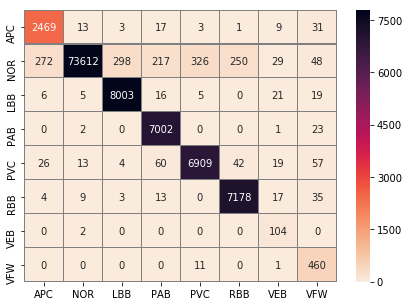

In [214]:
fig = plt.figure(figsize=(7, 5))
ax = sns.heatmap(conf_mtx_1, annot=True, fmt='d', cmap=sns.cm.rocket_r, 
                 xticklabels=x, yticklabels=x, robust=True, 
                 linewidths=0.1, linecolor='grey')

In [215]:
f1_scores = f1_score(labels_pred, labels_test, average=None)
f1_scores

[0.9276723652075897,
 0.9900207117303709,
 0.976809471500061,
 0.9756845258830905,
 0.960650723025584,
 0.9746096401900882,
 0.6775244299674266,
 0.8034934497816594]

Mean f1-score

In [216]:
np.mean(f1_scores)

0.9108081646607338